# DRAFT

In [1]:
import pystan
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import linspace,hstack
import seaborn as sns; sns.set_context('notebook')

In [2]:
%matplotlib inline

In [3]:
# Import data
fish_productivity = pd.read_csv('./fish_catch_LME_npp_cb_per_km2.txt', sep="\t")

In [4]:
fish_productivity.head(4)

,OBJECTID,LME_NUMBER,LME_NAME,SUM_GIS_KM,npp_sum_LME,mean_catch_tonnage_1950_2014,mean_catch_tonnage_10yr_2004_2014,npp_ton_carbon,npp_carbon_ton_per_km2,tenyr_catch_km2
0,60,1,East Bering Sea,1320000.0,2.540000e+17,817460.2,900743.1,254000000.0,192.42,0.682
1,4,2,Gulf of Alaska,1530000.0,3.270000e+17,871076.7,853269.1,327000000.0,213.73,0.558
2,10,3,California Current,2220000.0,4.120000e+17,865133.0,1036357.0,412000000.0,185.59,0.467
3,20,4,Gulf of California,223000.0,4.650000e+16,403243.5,565684.0,46500000.0,208.52,2.540


In [5]:
fish_productivity.describe()

,OBJECTID,LME_NUMBER,SUM_GIS_KM,npp_sum_LME,mean_catch_tonnage_1950_2014,mean_catch_tonnage_10yr_2004_2014,npp_ton_carbon,npp_carbon_ton_per_km2,tenyr_catch_km2
count,64.000000,64.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,64.000000,64.000000
mean,32.531250,32.515625,1.253031e+06,2.201125e+17,1.305330e+06,1.572794e+06,2.201125e+08,181.822031,1.496814
std,18.674292,18.646241,9.367712e+05,1.644576e+17,1.703443e+06,2.360390e+06,1.644576e+08,55.496956,2.004151
min,1.000000,1.000000,1.040000e+05,1.760000e+16,4.600801e+02,3.320988e+02,1.760000e+07,38.250000,0.000305
25%,16.750000,16.750000,6.195000e+05,1.097500e+17,1.433230e+05,1.566965e+05,1.097500e+08,152.557500,0.201500
50%,32.500000,32.500000,1.020000e+06,1.735000e+17,7.644404e+05,6.972654e+05,1.735000e+08,183.270000,0.719500
75%,48.250000,48.250000,1.485000e+06,2.940000e+17,1.891549e+06,1.628511e+06,2.940000e+08,206.622500,1.995000
max,66.000000,65.000000,4.340000e+06,6.990000e+17,9.753014e+06,1.221295e+07,6.990000e+08,330.260000,9.300000


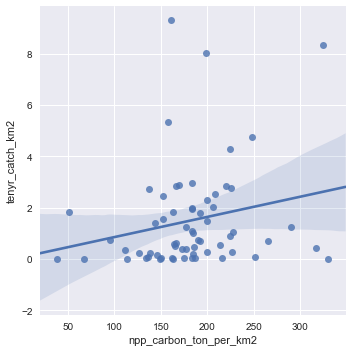

In [6]:
# Here we just want to plot the data over time. 
sns_plot = sns.lmplot("npp_carbon_ton_per_km2", "tenyr_catch_km2", data=fish_productivity, fit_reg=True)
sns_plot.savefig("fish_catch_vs_npp.png")

### Log transform the data

In [7]:
fish_productivity['log_tenyr_catch_km2'] = np.log(fish_productivity['tenyr_catch_km2'])
fish_productivity['log_npp_carbon_ton_per_km2'] = np.log(fish_productivity['npp_carbon_ton_per_km2'])

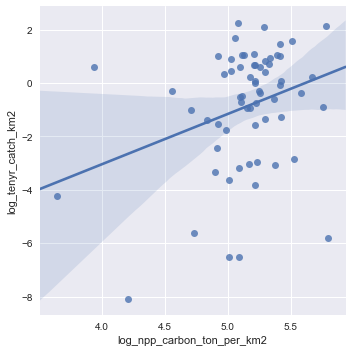

In [8]:
# Here we just want to plot the data over time. 
sns_plot = sns.lmplot("log_npp_carbon_ton_per_km2", "log_tenyr_catch_km2", data=fish_productivity, fit_reg=True)
sns_plot.savefig("log_fish_catch_vs_npp.png")

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/ara/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
catch_npp_model = ols("tenyr_catch_km2 ~ npp_carbon_ton_per_km2", data=fish_productivity).fit()

In [11]:
catch_npp_model_summary = catch_npp_model.summary()

In [12]:
catch_npp_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        tenyr_catch_km2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.090
Date:                Thu, 02 Nov 2017   Prob (F-statistic):             0.0837
Time:                        17:01:14   Log-Likelihood:                -133.25
No. Observations:                  64   AIC:                             270.5
Df Residuals:                      62   BIC:                             274.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0662      0.850      0.078      0.938      -1.634       1.766
npp_carbon_ton_per_km2     0.0079      0.004      1.758      0.084      -0.001       0.017
==============================================================================
Omnibus:                       42.483   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.229
Skew:                           2.115   Prob(JB):                     5.77e-26
Kurtosis:                       8.068   Cond. No.                         655.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Linear model graph code from http://www.learndatasci.com/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/, Tim Dobbins and John Burke, accessed 18/10/17 

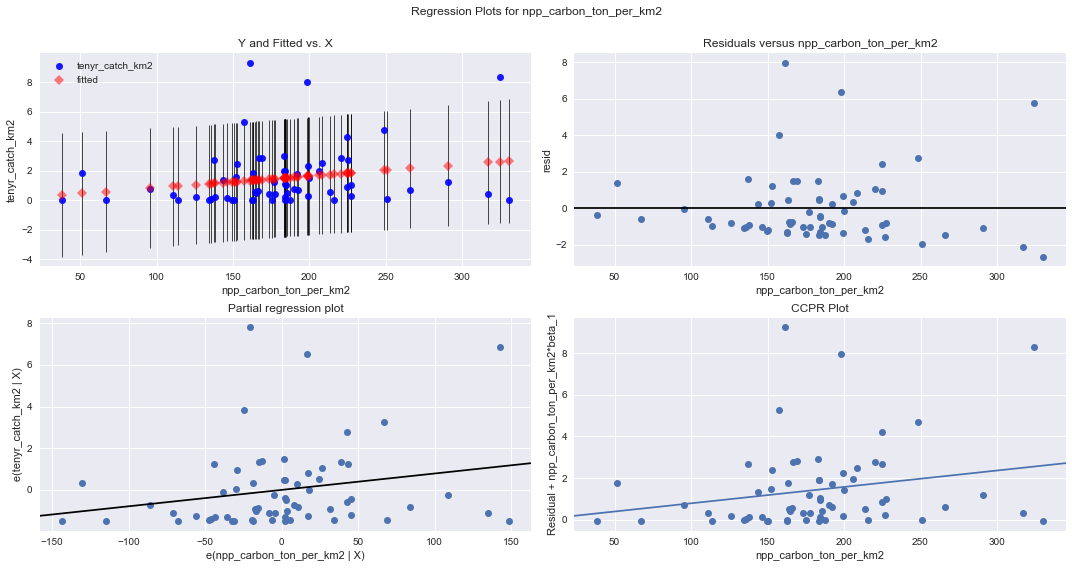

In [13]:
# use figsize to adjust size, and pass in to plot_regress_exog
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(catch_npp_model, "npp_carbon_ton_per_km2", fig=fig)

### Stan modelling section

In [14]:
x = fish_productivity.npp_carbon_ton_per_km2.tolist()
y = fish_productivity.tenyr_catch_km2.tolist()
N = len(x)

In [15]:
print(x)

[192.42, 213.73, 185.59, 208.52, 184.42, 173.27, 224.84, 190.18, 164.1, 162.44, 265.83, 146.34, 248.44, 290.6, 177.5, 184.26, 316.98, 137.96, 135.83, 166.16, 183.96, 220.46, 199.24, 183.73, 152.13, 95.65, 157.52, 163.21, 227.21, 199.24, 226.95, 176.96, 111.02, 183.47, 161.1, 183.07, 192.16, 200.0, 250.96, 183.72, 175.3, 150.42, 134.31, 187.29, 215.92, 164.95, 198.21, 324.26, 143.61, 137.37, 205.99, 225.0, 224.58, 126.12, 67.16, 113.92, 330.26, 162.79, 152.7, 169.23, 38.25, 51.4, 149.6, 166.8]


In [16]:
print(y)

[0.682, 0.5579999999999999, 0.467, 2.54, 1.01, 0.396, 4.28, 0.7490000000000001, 0.595, 0.0418, 0.69, 0.17300000000000001, 4.77, 1.24, 0.39799999999999996, 0.21100000000000002, 0.41, 0.214, 0.0864, 0.618, 1.09, 2.85, 2.29, 1.96, 1.56, 0.755, 5.33, 1.82, 1.06, 0.263, 0.28, 1.23, 0.365, 1.99, 9.3, 2.98, 1.8, 1.49, 0.0587, 0.0216, 0.0473, 0.0261, 0.0361, 0.0521, 0.0455, 0.5, 8.02, 8.36, 1.4, 2.73, 2.01, 2.75, 0.914, 0.248, 0.000305, 0.0036299999999999995, 0.0030600000000000002, 0.00145, 2.46, 2.88, 0.0146, 1.83, 0.00145, 2.84]


In [17]:
# make a dictionary containing all data to be passed to STAN
regress_dat = {'x': x,
 'y': y,
 'N': N}

In [18]:
regress_simple = """
data {
  int<lower=0> N;
  vector[N] y;
  vector[N] x;
}
parameters {
  vector[2] beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

In [19]:
# Fit the model
fit_simple = pystan.stan(model_code=regress_simple, data=regress_dat, verbose=True,
 iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52f929b40eb34cd97ae8591ae02a09aa NOW.
INFO:pystan:OS: darwin, Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.25.2


Compiling /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/stanfit4anon_model_52f929b40eb34cd97ae8591ae02a09aa_5383024842126280373.pyx because it changed.
[1/1] Cythonizing /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/stanfit4anon_model_52f929b40eb34cd97ae8591ae02a09aa_5383024842126280373.pyx
building 'stanfit4anon_model_52f929b40eb34cd97ae8591ae02a09aa_5383024842126280373' extension
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var/folders
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var/folders/sz
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpd3e58lkq/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0

In [503]:
print(fit_simple)

Inference for Stan model: anon_model_52f929b40eb34cd97ae8591ae02a09aa.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   0.06    0.02   0.87  -1.66  -0.52   0.06   0.64   1.76   2543    1.0
beta[1] 7.9e-3  8.9e-5 4.6e-3-1.2e-3 4.8e-3 7.9e-3   0.01   0.02   2630    1.0
sigma     2.01  3.0e-3   0.18   1.69   1.88    2.0   2.12   2.41   3770    1.0
lp__    -75.29    0.02   1.24 -78.57 -75.84 -74.97 -74.38 -73.88   2957    1.0

Samples were drawn using NUTS at Thu Oct 19 07:53:11 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [504]:
regress_simple_para = """
data {
  int<lower=0> N;
  vector[N] y;
  vector[N] x;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}
"""

In [505]:
# Fit the model
regress_simple_para = pystan.stan(model_code=regress_simple_para, data=regress_dat, verbose=True,
 iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c862b13cc9c9844fa617175a5bb39e00 NOW.
INFO:pystan:OS: darwin, Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.25.2


Compiling /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/stanfit4anon_model_c862b13cc9c9844fa617175a5bb39e00_328441496914097200.pyx because it changed.
[1/1] Cythonizing /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/stanfit4anon_model_c862b13cc9c9844fa617175a5bb39e00_328441496914097200.pyx
building 'stanfit4anon_model_c862b13cc9c9844fa617175a5bb39e00_328441496914097200' extension
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var/folders
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var/folders/sz
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp42m_sm0a/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000

In [506]:
print(regress_simple_para)

Inference for Stan model: anon_model_c862b13cc9c9844fa617175a5bb39e00.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.08    0.02   0.88  -1.62   -0.5   0.07   0.67   1.82   2753    1.0
beta  7.7e-3  8.8e-5 4.6e-3-1.4e-3 4.7e-3 7.9e-3   0.01   0.02   2753    1.0
sigma   2.02  3.1e-3   0.19   1.69   1.88    2.0   2.13   2.43   3660    1.0
lp__  -75.31    0.03   1.27 -78.67 -75.87  -75.0  -74.4 -73.87   2572    1.0

Samples were drawn using NUTS at Thu Oct 19 07:54:57 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [553]:
regress_priors = """
data {
  int<lower=0> N;
  vector[N] y;
  vector[N] x;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0,10);    
  beta ~ cauchy(0,5);
  sigma ~ cauchy(0,5);

  for (n in 1:N)
    y[n] ~ normal(alpha + beta * x[n], sigma);
}
"""

In [554]:
# Fit the model
regress_priors_fit = pystan.stan(model_code=regress_priors, data=regress_dat, verbose=True,
 iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb00f22a4ebdfb110e655ea043db86a2 NOW.
INFO:pystan:OS: darwin, Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.25.2


Compiling /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/stanfit4anon_model_eb00f22a4ebdfb110e655ea043db86a2_464605767353621163.pyx because it changed.
[1/1] Cythonizing /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/stanfit4anon_model_eb00f22a4ebdfb110e655ea043db86a2_464605767353621163.pyx
building 'stanfit4anon_model_eb00f22a4ebdfb110e655ea043db86a2_464605767353621163' extension
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var/folders
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var/folders/sz
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp54pod7_o/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000

In [555]:
print(regress_priors_fit)

Inference for Stan model: anon_model_eb00f22a4ebdfb110e655ea043db86a2.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.08    0.02   0.84  -1.55  -0.49   0.07   0.64   1.75   2480    1.0
beta  7.8e-3  9.1e-5 4.4e-3-9.1e-4 4.8e-3 7.9e-3   0.01   0.02   2357    1.0
sigma   2.01  3.1e-3   0.18   1.69   1.88    2.0   2.12   2.42   3503    1.0
lp__  -75.44    0.03   1.26 -78.73 -75.99 -75.09 -74.53 -74.03   2428    1.0

Samples were drawn using NUTS at Thu Oct 19 09:28:45 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


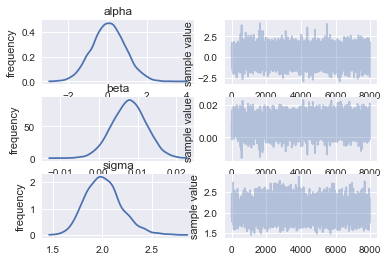

In [556]:
# show a traceplot of ALL parameters. This is a bear if you have many
regress_priors_fit.traceplot()
plt.show()

In [557]:
import stan_utility

In [558]:
stan_utility.check_treedepth(regress_priors_fit)

0 of 8000 iterations saturated the maximum tree depth of 10 (0.0%)


In [559]:
stan_utility.check_energy(regress_priors_fit)

In [560]:
stan_utility.check_div(regress_priors_fit)

0.0 of 8000 iterations ended with a divergence (0.0%)


In [561]:
##### PREDICTION ####
 
# make a dataframe of parameter estimates for all chains
samples = regress_priors_fit.extract(permuted=True)
params = pd.DataFrame({'a': samples['alpha'], 'b': samples['beta']})
len(samples['alpha'])
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
 fitted = p[0] + p[1] * predX
 return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(0, 400 )
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)

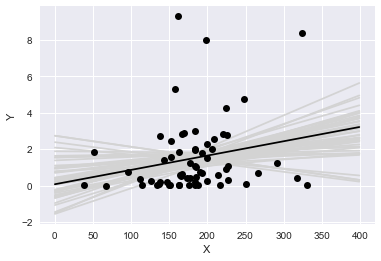

In [562]:
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
 plt.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data
plt.plot(x,y, 'ko')
# fitted values
plt.plot(predX, yhat['fitted'], 'k')
 
# supplementals
plt.xlabel('X')
plt.ylabel('Y')
 
plt.show()

### Running with simulated data to test the model.

In [24]:
import random

In [87]:
x_tilde = random.sample(range(50, 350), 64)
N_tilde = len(x_tilde)

In [88]:
np.mean(x_tilde, axis=0)

198.625

In [89]:
# make a dictionary containing all data to be passed to STAN
regress_sim_dat = {'x': x,
 'y': y,
 'N': N,
 'x_tilde':x_tilde,
 'N_tilde':N_tilde}

In [104]:
 regress_sim = """
 data {
   int<lower=0> N;
   vector[N] y;
   vector[N] x;
   int<lower=0> N_tilde;
   vector[N_tilde] x_tilde;
 }
 parameters {
   real alpha;
   real beta;
   real<lower=0> sigma;
 }
 model {
   alpha ~ normal(0,10);    
   beta ~ cauchy(0,5);
   sigma ~ cauchy(0,5);
 
   for (n in 1:N)
     y[n] ~ normal(alpha + beta * x[n], sigma);
 }
 generated quantities {
    vector[N_tilde] y_tilde;
       
    for (n in 1:N_tilde)
      y_tilde[n] = normal_rng(alpha + beta * x_tilde[n], sigma);
 }
 """

In [105]:
# Fit the model
regress_sim_fit = pystan.stan(model_code=regress_sim, data=regress_sim_dat, verbose=True,
 iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ed234ee0a063e027feeb0fef8f674c7 NOW.
INFO:pystan:OS: darwin, Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.25.2


Compiling /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/stanfit4anon_model_0ed234ee0a063e027feeb0fef8f674c7_4749471331243328630.pyx because it changed.
[1/1] Cythonizing /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/stanfit4anon_model_0ed234ee0a063e027feeb0fef8f674c7_4749471331243328630.pyx
building 'stanfit4anon_model_0ed234ee0a063e027feeb0fef8f674c7_4749471331243328630' extension
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var/folders
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var/folders/sz
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmp5pux2h53/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0

In [106]:
print(regress_sim_fit)

Inference for Stan model: anon_model_0ed234ee0a063e027feeb0fef8f674c7.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha         0.07    0.02   0.87  -1.63  -0.52   0.06   0.67   1.77   3055    1.0
beta        7.8e-3  8.4e-5 4.6e-3-1.2e-3 4.7e-3 7.8e-3   0.01   0.02   2955    1.0
sigma         2.01  3.0e-3   0.18   1.69   1.88    2.0   2.12   2.41   3689    1.0
y_tilde[0]    2.32    0.02   2.07  -1.77    0.9   2.33   3.72   6.41   7596    1.0
y_tilde[1]     0.9    0.02   2.05  -3.18  -0.48   0.92   2.24   4.96   6999    1.0
y_tilde[2]    1.33    0.02   2.02  -2.64  -0.02   1.34   2.66    5.3   8000    1.0
y_tilde[3]    1.11    0.02   2.05  -2.96  -0.26   1.11   2.49   5.11   8000    1.0
y_tilde[4]    1.61    0.02   2.04   -2.4   0.23   1.62   2.95   5.64   8000    1.0
y_tilde[5]    1.46    0.02   2.02  -2.48   0.12   1.47   2.82   

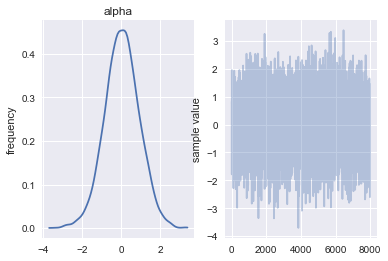

In [93]:
# Instead, show a traceplot for single parameter
regress_sim_fit.plot(['alpha'])
plt.show()

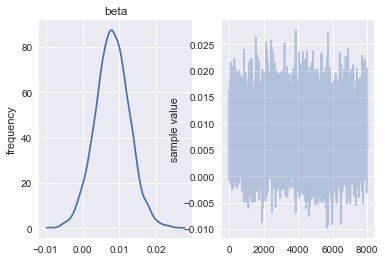

In [94]:
# Instead, show a traceplot for single parameter
regress_sim_fit.plot(['beta'])
plt.show()

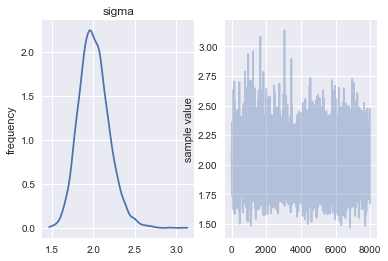

In [95]:
# Instead, show a traceplot for single parameter
regress_sim_fit.plot(['sigma'])
plt.show()

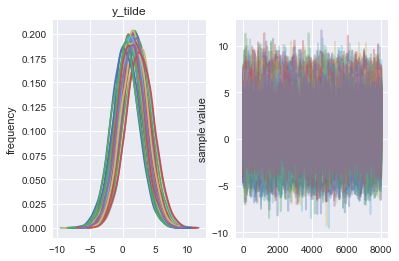

In [96]:
# Instead, show a traceplot for single parameter
regress_sim_fit.plot(['y_tilde'])
plt.show()

In [97]:
samples = regress_sim_fit.extract(permuted=True)

In [98]:
y_tilde = samples['y_tilde']

In [ ]:
y_tilde_mean = np.mean(y_tilde, axis=0)

In [107]:
y_tilde_mean

array([ 1.56852173,  1.76669175,  1.48395373,  1.71829964,  1.49039532,
        1.46947366,  1.83476897,  1.60391257,  1.3447011 ,  1.35001725,
        2.23765214,  1.21444336,  2.03600095,  2.34986072,  1.44421889,
        1.52294092,  2.61229909,  1.14737642,  1.09663709,  1.38941223,
        1.526749  ,  1.81984274,  1.5971207 ,  1.52794554,  1.27638687,
        0.83286082,  1.31000546,  1.34995549,  1.86803   ,  1.6149556 ,
        1.88332555,  1.46254536,  0.92225404,  1.5093105 ,  1.31962066,
        1.48336891,  1.58756688,  1.67219315,  2.05004746,  1.5562272 ,
        1.43357498,  1.29720127,  1.1195981 ,  1.52754388,  1.74385111,
        1.40340209,  1.66162074,  2.63764083,  1.16909849,  1.14082128,
        1.71181985,  1.8670579 ,  1.8443812 ,  1.05006134,  0.60817989,
        0.95995055,  2.68541968,  1.35286154,  1.24760228,  1.37954421,
        0.33470239,  0.46325973,  1.23937516,  1.36419296])